# SWMM with Python Week 2: Sensitivity Analysis

A model will never get tired when you are keep asking what if questions. And when it comes to learning, try something and see what happens is universal.

To me as a modeler, the most important thing when building a model is learning. Just like taking my driving road test, reading and watching everything I can find about the test will not get me pass it. I have to give it a try, more on the magnitude of thousands tries before I can pass it.

When working with a model, it is the same idea. I need to watch the model running hundreds of times before I can pass the test. And sensitivty analysis to a very large extent means the same thing. It is just a more systematic way of learning what parameters matters more for a model.

Before we can do sensitivity analysis, I need to figure out the following,
- change the parameter in the swmm model and run it in python
- run the models and compare the results

Let's get the programming part figured out first before we get deeper into sensitivity analysis.


## jinja2 templating

I've done some web development many years ago, and I used [jinja2](https://jinja.palletsprojects.com/en/2.11.x/) for rendering web pages using templates. And that works perfect for our purposes, when we change the parameters of a swmm input file, the rest stays the same and we only change a few values.

Say if I need to adjust the R1 values in my model, all I need to do is to replace the r1 value with {{ r1 }}, then I can pass the data {'r1': 0.5} to update the input file using a value of 0.5.

```
[HYDROGRAPHS]
;;Hydrograph     Rain Gage/Month  Response R        T        K        Dmax     Drecov   Dinit   
;;-------------- ---------------- -------- -------- -------- -------- -------- -------- --------
test             a               
test             All              Short    {{ r1 }}        0.5      2        0        0        0       
test             All              Medium   0        2        2        0        0        0       
test             All              Long     0        4        8        0        0        0       


```

And a more advanced example is that I can render an input file from a table. The following will render an input file of node coordinates from a table.

```python
data = [{'name': '1', 'x': 100, 'y': 100},
        {'name': '2', 'x': 200, 'y': 200},
        {'name': '3', 'x': 300, 'y': 300}]
```

```
[COORDINATES]
;;Node           X-Coord            Y-Coord           
;;-------------- ------------------ ------------------
{% for node in nodes %}
{{ node['name'] }}       {{ node['x'] }}      {{ node['y'] }}
{% endfor %}
```



I couldn't get the model to run using my inp file, says some errors in input file. OK running the testing inp file.
```python
from swmm.toolkit import toolkit as smtk
def run(inp_name):
    _handle = smtk.alloc_project()
    smtk.run(_handle, inp_name, inp_name.replace('.inp', '.rpt'), inp_name.replace('.inp', '.out'))
    smtk.free_project(_handle)
```

I got a permission error running the code below in jupyer lab
```python
import subprocess

def run(inp_path):
    swmm5_path = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\tmp\data\bin\swmm5.exe"
    subprocess.Popen([r"cmd"])
    line = r'"%s" "%s" "%s" "%s"' % (swmm5_path,  inp_name, inp_name.replace('.inp', '.rpt'), inp_name.replace('.inp', '.out'))
    print(line)
    subprocess.Popen([r'"%s" "%s" "%s" "%s"' % (swmm5_path,  inp_name, inp_name.replace('.inp', '.rpt'), inp_name.replace('.inp', '.out'))])
    
```

The render_input function will use jinja2 to render a template to a new input file from the data supplied.

In [1]:
from jinja2 import Environment, FileSystemLoader
import logging

def render_input(tmp_folder,tmp_name,  data, out_inp):
    '''
    render an input file using a template.
    tmp_folder: folde where the template inp file is.
    tmp_name: name of the template file
    data: the data to be applied to the template
    out_inp: the inp file with values applied
    '''
    env = Environment(loader=FileSystemLoader(tmp_folder))
    template = env.get_template(tmp_name)
    output_from_parsed_template = template.render(data)
    # to save the results
    with open(out_inp, "w") as fh:
        fh.write(output_from_parsed_template)
        logging.info('inp created:%s' % out_inp)

To run the model, I use pyswmm and created a run function.

In [2]:
from pyswmm import Simulation, Subcatchments
import matplotlib.pyplot as plt
# def run(inp_path):
#     # there seems to be a bug in the lib that failed to read the input file
#     with Simulation(inp_path) as sim:
#         for step in sim: #it crashes if I don't go through this.
#             pass
#         sim.report()

def run(inp_path):
    sim = Simulation(inp_path)
    sim.execute()


Below are some helper functions to extract the results from the output file.

In [3]:
from swmm.output import output as smo
import pandas as pd
import datetime

def swmm_dt(days):
    # convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1

def extract_flow(out_path, node_index=0):
    # extract the node results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)

    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.NODE, 0))

    # get the time sereis from the out file
    values = smo.getnodeseries(handle, 0, smo.NodeAttribute.TOTAL_INFLOW, 0, num_steps)
    df = pd.DataFrame({'total_flow': values}, index=timestep)
    return df

## The model

I would like to test the impact of time step on RTK hydrology results. I built a single node model with only RTK hdyrology.

- area: 1ac
- rtk: only r1= 0.5/2/1, r2, r3 are 0
- rainfall: 1in/hr for the 1st hour

C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\r000030.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\r000100.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\r000200.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\r000300.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\r000400.inp

... SWMM Version 5.3.0.dev0
... Run Complete1


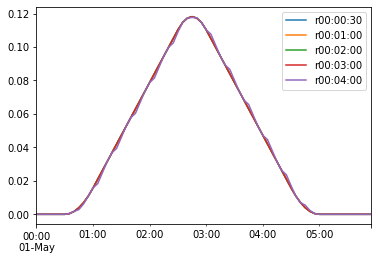

,r00:00:30,r00:01:00,r00:02:00,r00:03:00,r00:04:00
count,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.042015,0.042015,0.042015,0.042015,0.042015
std,0.041694,0.041694,0.041694,0.041694,0.041677
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.031512,0.031512,0.031512,0.031512,0.031512
75%,0.078779,0.078779,0.078779,0.078779,0.079107
max,0.118168,0.118168,0.118168,0.118168,0.117731


In [4]:
import time
tmp_folder = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\tmp'
tmp_name = 'rtk_routing_step.inp'

dfs = None

for i in ['00:00:30', '00:01:00', '00:02:00', '00:03:00', '00:04:00']: #, '00:05:00', '00:30:00', '00:60:00']:
    out_inp = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\r%s.inp' % (i.replace(':', ''))
    out_path = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\r%s.out' % (i.replace(':', ''))
    print(out_inp)
    data = {'routing_step': i}
    render_input(tmp_folder,tmp_name,  data, out_inp)
    run(out_inp)
    df = extract_flow(out_path, node_index=0)
    if dfs is None:
        df['r%s' % i] = df['total_flow']
        dfs = df.loc[:, ['r%s' % i]].copy()
        
    else:
        dfs['r%s' % i] = df['total_flow']
        
dfs.plot()

plt.show()
dfs.describe()

As shown above, changing the routing time step from 30 sec to 4 min showed the same results. So we know the routing time step probably doesn't have any impact on RTK hydrology without knowing anything about how it is implemented in SWMM. And this is a great news for modelers, many times, you don't need to know how things work internally to get some idea how they work. And that's the power of sensitivity analysis.

So if routing time step is not used for RTK hydrology calculation, then at what time step does RTK calculates the flow? It might be the time step of the rainfall data, so let's run some analysis of different rainfall time steps.

# Rainfall Data

So in this model we have a constant 1 in/hr rainfall lasted for 1hr at the beginning of the model, and we can represented as many forms,

- at 1hr time step
```
[TIMESERIES]
;;Name           Date       Time       Value     
;;-------------- ---------- ---------- ----------
rg_a                        00:00      1         
rg_a                        01:00      0     
```
- at 30 min step, we'll have 
```
[TIMESERIES]
;;Name           Date       Time       Value     
;;-------------- ---------- ---------- ----------
rg_a                        00:00      1         
rg_a                        00:30      1
rg_a                        01:00      0

```


C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\0100.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\0030.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\0015.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\0005.inp

... SWMM Version 5.3.0.dev0
... Run Complete1


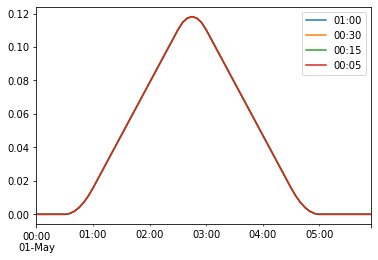

,01:00,00:30,00:15,00:05
count,72.000000,72.000000,72.000000,72.000000
mean,0.042015,0.042015,0.042015,0.042015
std,0.041694,0.041694,0.041694,0.041694
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.031512,0.031512,0.031512,0.031512
75%,0.078779,0.078779,0.078779,0.078779
max,0.118168,0.118168,0.118168,0.118168


In [5]:
rainfall_1hr = [['00:00', 1],
               ['01:00', 0]]

rainfall_30min = [['00:00', 1],
                   ['00:30', 1],
                  ['01:00', 0]]


rainfall_15min = [['00:00', 1],
                   ['00:15', 1],
                  ['00:30', 1],
                  ['00:45', 1],
                  ['01:00', 0]]


rainfall_5min = [['00:00', 1],
                   ['00:05', 1],
                  ['00:10', 1],
                 ['00:15', 1],
                 ['00:20', 1],
                 ['00:25', 1],
                  ['00:30', 1],
                 ['00:35', 1],
                 ['00:40', 1],
                 ['00:45', 1],
                 ['00:50', 1],
                 ['00:55', 1],
                  ['01:00', 0]]


tmp_folder = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\tmp'
tmp_name = 'rtk_rainfall.inp'
dfs = None
for rf_name, rainfall in zip(['01:00', '00:30', '00:15', '00:05'], [rainfall_1hr, rainfall_30min, rainfall_15min, rainfall_5min]):
    out_inp = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\%s.inp' % rf_name.replace(':', '')
    out_path = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\%s.out' % rf_name.replace(':', '')
    print(out_inp)
    data = {'lines': rainfall, 'interval': rf_name}
    render_input(tmp_folder,tmp_name,  data, out_inp)
    run(out_inp)
    df = extract_flow(out_path, node_index=0)
    if dfs is None:
        df[rf_name] = df['total_flow']
        dfs = df.loc[:, [rf_name]].copy()
        
    else:
        dfs[rf_name] = df['total_flow']
        
dfs.plot()

plt.show()
dfs.describe()
    


1
1
1
1
1
1
1
1
1


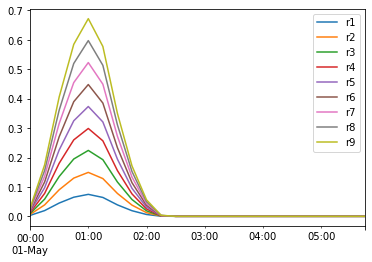

In [14]:
dfs = None
for i in range(1, 10):
    out_path = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\tmp\data\out\r%s.out' % i
    df = extract_flow(out_path, node_index=0)
    csv_path = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\tmp\data\out\r%s.csv' % i
#     df.to_csv(csv_path, index_label='datetime')
    
    
    if dfs is None:
        df['r%s' % i] = df['total_flow']
        dfs = df.loc[:, ['r%s' % i]].copy()
        
    else:
        dfs['r%s' % i] = df['total_flow']
    

dfs.plot()

plt.show()

In [ ]:
dfs.max()

In [16]:
dfs

[                           r1
 2020-05-01 00:00:00  0.003112
 2020-05-01 00:15:00  0.019452
 2020-05-01 00:30:00  0.045128
 2020-05-01 00:45:00  0.064968
 2020-05-01 01:00:00  0.074694
 2020-05-01 01:15:00  0.064190
 2020-05-01 01:30:00  0.038903
 2020-05-01 01:45:00  0.019063
 2020-05-01 02:00:00  0.006225
 2020-05-01 02:15:00  0.000389
 2020-05-01 02:30:00  0.000000
 2020-05-01 02:45:00  0.000000
 2020-05-01 03:00:00  0.000000
 2020-05-01 03:15:00  0.000000
 2020-05-01 03:30:00  0.000000
 2020-05-01 03:45:00  0.000000
 2020-05-01 04:00:00  0.000000
 2020-05-01 04:15:00  0.000000
 2020-05-01 04:30:00  0.000000
 2020-05-01 04:45:00  0.000000
 2020-05-01 05:00:00  0.000000
 2020-05-01 05:15:00  0.000000
 2020-05-01 05:30:00  0.000000
 2020-05-01 05:45:00  0.000000,                            r2
 2020-05-01 00:00:00  0.006225
 2020-05-01 00:15:00  0.038903
 2020-05-01 00:30:00  0.090255
 2020-05-01 00:45:00  0.129937
 2020-05-01 01:00:00  0.149388
 2020-05-01 01:15:00  0.128380
 2020-05

In [11]:
_handle = smtk.alloc_project()
inp_name = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\tmp\data\out\r1.inp'
smtk.run(_handle, inp_name, inp_name.replace('.inp', '.rpt'), inp_name.replace('.inp', '.out'))
smtk.free_project(_handle)

Exception: 
  ERROR 200: one or more errors in input file.